# Santa Claus the Engineer!

In [21]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question:

Suppose Santa is trying to speed up the already quick present-giving process on Christmas Eve. Instead of going to the roof of every building on Olin's campus, he decides to land on West Hall and launch all his presents to the tops of the other four buildings. He has a launcher that can launch presents at any velocity and angle that he desires (because Santa is an engineer).

At what angle and final velocity will optimize Santa's needed force to launch his presents to all the other campus buildings?

#define units

m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
feet = UNITS.feet
inch = UNITS.inch
degree = UNITS.degree;

Here are the heights of Olin's five buildings, according to the building plans.

In [68]:
WH_height = (53*feet + 1.625*inch).to(m) #16.196 m

AC_height = (67*feet).to(m) - WH_height #20.422 m
CC_height = (62*feet + 4* inch).to(m) - WH_height #18.992 m
MH_height = (54*feet + 5.375*inch).to(m) - WH_height #15.596 m
EH_height = (48*feet + 11.25*inch).to(m) - WH_height #14.916 m

<Quantity(-1.2795249999999996, 'meter')>

... and the approximate distances between West Hall and the other four buildings (estimated on Google Maps).

In [69]:
to_EH = 80.88*m
to_CC = 72.69*m
to_AC = 141.29*m
to_MH = 108.69*m;

Now we need to create "params" and our System variable.  We'll start off by assuming Santa's launcher launches presents at a speed of 40m/s.

In [70]:
#create parameters
params = Params(x = 0 * m, 
                y = 0 * m,
                g = 9.81 * m/s**2,
                mass = 1.0206 * kg,
                height = 0.3048 * m,
                length = 0.3048 * m,
                width = 0.3048 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.8,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 100 * s)

,values
x,0 meter
y,0 meter
g,9.81 meter / second ** 2
mass,1.0206 kilogram
height,0.3048 meter
length,0.3048 meter
width,0.3048 meter
rho,1.2 kilogram / meter ** 3
C_d,0.8
angle,45 degree


In [71]:
#create our system object

def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = height*length*height
    
    return System(params, init=init, area=area)

In [72]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [73]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [74]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y+0.0001

In [75]:
params = make_system(params)
results, details = run_ode_solver(params, slope_func, max_step=0.5*s, events = event_func)
details.message

'A termination event occurred.'

In [76]:
results.tail()

,x,y,vx,vy
2.392819,45.457752,22.754604,13.935293,-3.966550
2.892819,52.097686,19.677338,12.636463,-8.267918
3.392819,58.099844,14.565815,11.374198,-12.093849
3.892819,63.473472,7.672224,10.122883,-15.388633
4.352326,67.865150,-0.000100,8.997968,-17.927378


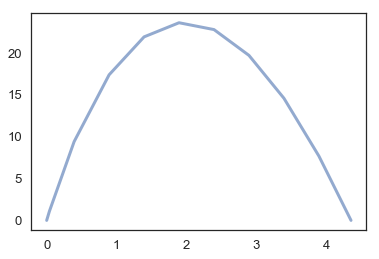

In [77]:
plot(results.y)

In [63]:
def event_func2(state, t, system, dist_end):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return x-dist_end

def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    print(angle)
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func2)
    y_dist = get_last_value(results.y) * m
    return y_dist

In [64]:
res1 = max_bounded(height_func, [0, 90], params)
optimal_angle_length = res1.x * degree

34.37694101250946
55.62305898749054
21.246117974981075
28.077330702495093
30.62511136707378
30.75049102400633
30.917758753455946
30.90006346541506
30.89952845131918
30.899194659671775


<Quantity(30.89952845131918, 'degree')>

In [65]:
def error_func(v, params, h_end):
    this_params = Params(params, velocity=v)
    optimal_height = max_bounded(height_func, [0,90], this_params)
    height = optimal_height.fun
    return height - (WH_height-h_end)

In [67]:
answer = fsolve(error_func, 45*m, params, EH);
print (answer[0]*m/s)

34.37694101250946
55.62305898749054
21.246117974981075
30.095115348960196
37.186219007453026
35.40806710245242
35.465649694075275
35.5023701686017
35.49988796277859
35.49955410289682
35.50022182266035
34.37694101250946
55.62305898749054
21.246117974981075
30.095115348960196
37.186219007453026
35.40806710245242
35.465649694075275
35.5023701686017
35.49988796277859
35.49955410289682
35.50022182266035
34.37694101250946
55.62305898749054
21.246117974981075
30.095115348960196
37.186219007453026
35.40806710245242
35.465649694075275
35.5023701686017
35.49988796277859
35.49955410289682
35.50022182266035
34.37694101250946
55.62305898749054
21.246117974981075
30.095115348960196
37.186219007453026
35.40806710245242
35.465649694075275
35.5023701686017
35.49988796277859
35.49955410289682
35.50022182266035
34.37694101250946
55.62305898749054
21.246117974981075
30.09511566664703
37.18621995240186
35.40806765495598
35.465650237492326
35.50237073892145
35.499888530987405
35.499554671105635
35.500222390